(counts_prediction_notebook)=
# La predizione delle frequenze 

In ambito bayesiano, la predizione delle frequenze si riferisce al problema di prevedere il numero di volte che un evento si verificherà in futuro, sulla base delle informazioni disponibili. Questo problema è spesso affrontato utilizzando il teorema di Bayes, che consente di calcolare la probabilità di un evento sulla base delle informazioni precedenti e delle nuove informazioni acquisite.

Per fare ciò, si utilizza una distribuzione a priori per rappresentare le nostre credenze iniziali sulla frequenza dell’evento e si aggiorna questa distribuzione utilizzando le nuove informazioni acquisite. La distribuzione risultante, ovvero la distribuzione a posteriori, rappresenta le nostre credenze aggiornate sulla frequenza dell’evento e può essere utilizzata per fare previsioni sulle future occorrenze dell’evento.

Per fare un esempio di questo approccio, in questo capitolo faremo riferimento alla ricerca sul trauma. In questo campo di ricerca, come in altri, il risultato di interesse può essere rappresentato dalla frequenza del numero di episodi che si verificano in un dato periodo di tempo. Nel caso della ricerca sulla violenza domestica, ad esempio, potremmo esaminare il tasso di atti aggressivi durante l'intervallo tra un momento temporale di baseline e un'intervista di follow-up. Altri esempi di risultati esprimibili in termini di frequenze nalla ricerca post-traumatica includono la frequenza dell'abuso di sostanze durante un periodo di osservazione o il numero di interventi della polizia durante un dato periodo.

Nell'esempio seguente esamineremo l'uso della predizione bayesiana per predire il numero di aggressioni nei confronti del partner nelle relazioni di coppia. I dati presentati sono tratti da uno studio che esamina la frequenza di episodi di aggressione messi in atto da pazienti di sesso maschile che avevano recentemente iniziato un programma di trattamento dell'alcol nei confronti del loro partner di sesso femminile.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import statistics
import arviz as az
import seaborn as sns
import scipy.stats as st 
import pymc as pm
import xarray as xr
from scipy.constants import golden
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline
sns.set_theme(
    context="paper",
    style="darkgrid",
    palette="colorblind",
    rc={'figure.figsize': (5.0, 5.0/golden)},
)
SEED = 42
rng = np.random.default_rng(SEED)

La frequenza degli episodi di violenza, così come altri fenomeni quantificabili in termini di frequenze assolute, può essere modellata da un processo di Poisson, che si basa sul presupposto che gli eventi siano casuali e abbiano la stessa probabilità di verificarsi in qualsiasi momento. Naturalmente, questa ipotesi non è sempre valida, ma spesso è sufficiente per la modellazione. 

## La distribuzione a priori

In una ricerca sui pazienti che avevano recentemente iniziato un programma di trattamento per l'abuso o la dipendenza da alcol, {cite:t}`gagnon2008poisson` hanno trovato che, in un periodo di 6 mesi, il numero di assalti fisici da parte dei pazienti di genere maschile nei confronti del loro partner femminile è uguale, in media, a 11.46 ($SD$ = 25.79; $n$ = 114). 

Per questi dati, è dunque sensato pensare che la distribuzione del numero di episodi di aggressione fisica può essere rappresentata dalla distribuzione esponenziale.

Ricordiamo che la distribuzione esponenziale modella il numero di eventi che si verificano in un intervallo di tempo quando questi eventi si verificano raramente e indipendentemente l’uno dall’altro.

La funzione di densità di probabilità della distribuzione esponenziale è data da:

$$
f(x) = λe^(-λx)
$$

dove λ è il parametro della distribuzione, che rappresenta il tasso medio di occorrenza degli eventi. La media e la varianza della distribuzione esponenziale sono entrambe uguali a 1/λ.

Poniamoci dunque il problema di rappresentare le nostre credenze a priori relative al numero di episodi di aggressione fisica mediante una distribuzione esponenziale.

Dalla ricerca di {cite:t}`gagnon2008poisson` sappiamo che, in un periodo di 6 mesi, il numero di assalti fisici nei confronti del partner femminile, in questa popolazione, è uguale a 11.46.

 Considereremo una distribuzione esponenziale per rappresentare le nostre credenze a priori circa la frequenza media $\mu$ degli episodi di aggressione nei confronti del partner per questa popolazione, in un periodo di 6 mesi. In Python, `scipy.stats.expon` è un modulo che fornisce funzioni per lavorare con la distribuzione esponenziale. In particolare, la funzione `pdf` (probability density function) calcola la funzione di densità di probabilità della distribuzione esponenziale per un dato valore di x.

 La sintassi per utilizzare questa funzione è la seguente:

 `
from scipy.stats import expon
expon.pdf(x, loc=0, scale=1)
 `

 dove `x` è il valore per il quale si vuole calcolare la funzione di densità di probabilità. Il parametro `loc`(opzionale) e `scale` specificano rispettivamente la posizione e la scala della distribuzione. La posizione (`loc`) di solito è impostata a 0, mentre la scala (`scale`) è l’inverso del parametro λ della distribuzione esponenziale. In altre parole, la scala è uguale alla media della distribuzione esponenziale. 

 Per il caso presente, dunque, se vogliamo che la distribuzione esponenziale abbia una media di 11.46, procediamo come indicato sotto

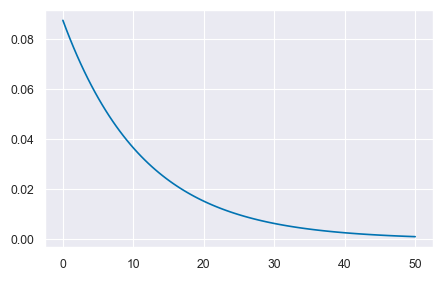

In [9]:
x = np.linspace (0, 50, 100) 
y = st.expon.pdf(x, 0, 11.46)
plt.plot(x, y)

Per verificare che abbiamo implementato correttamente la funzione esponenziale con il parametro voluto, estraiamo un grande numero di realizzazioni della v.c. e calcoliamo la media.

In [10]:
r = st.expon.rvs(0, 11.46, size=100000)
r.mean()

11.537295408288394

Una volta capito come descrivere le nostre credenze a priori, poniamoci il problema di usare PyMC per l'inferenza Bayesiana.

Consideriamo un singlo individuo di genere maschile appartenente a questa popolazione. Se, in media, in 6 mesi ci aspettiamo un numero di episodi di violenza pari a 11.46, possiamo descrivere il numero di episodi di violenza per un singolo individuo con la seguente distribuzione esponenziale. Si noti che, in questo caso, la funzione `pm.Exponential` è parametrizzata usando il parametro `l` che è uguale a $\lambda = 1/ \mu$.

In [13]:
l = 1/11.46

with pm.Model() as model:
    mu = pm.Exponential("mu", l)
    idata = pm.sample_prior_predictive(samples=10000, random_seed=rng)

Sampling: [mu]


Esaminiamo 10000 campioni casuali estratti dalla distribuzione a priori. Il risultato è simile alla distribuzione di densità teorica rappresentata nel grafico precedente.

<Axes: title={'center': 'mu'}>

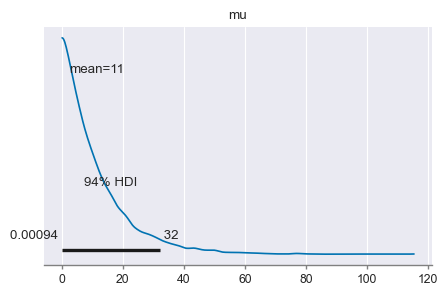

In [14]:
az.plot_posterior(idata.prior.mu)

Adesso inseriamo nel modello PyMC la verosimiglianza. 

In questo caso, usiamo quale modello generativo dei dati una distribuzione di Poisson. La verosimiglianza di Poisson è simile a quella Binomiale, con la differenza che, nella Binomiale il numero di "successi" non può essere maggiore di $n$ (il numero di prove) mentre, nella distribuzione di Poisson non c'è un limite superiore. 

Consideriamo uno specifico paziente -- chiamiamolo Mario.  Usando gli item della sottoscala relativa agli episodi di violenza fisica della *Conflict Tactics Scales-2* troviamo, per Mario, un numero di episodi violenti nei confronti del partner negli ultimi 6 mesi è uguale a 8. 

Inseriamo dunque questa informazione nel modello bayesiano.

In [15]:
with pm.Model() as model:
    mu = pm.Exponential("mu", l)
    episodes = pm.Poisson("episodes", mu, observed=8)
    idata2 = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Estraiamo da `idata2` i campioni della distribuzione a posteriori del parametro `mu` (media del numero di episodi di violenza negli ultimi 6 mesi).

In [9]:
sample_posterior = idata2.posterior['mu']

Generiamo un grafico della distribuzione a posteriori del parametro `mu`.

<Axes: title={'center': 'mu'}>

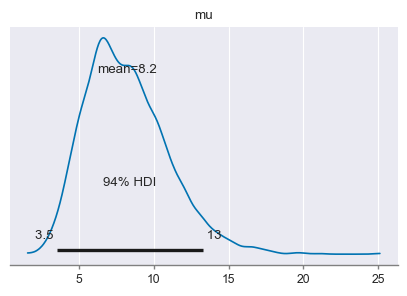

In [10]:
az.plot_posterior(sample_posterior)

Possiamo dunque concludere, con un livello di certezza soggettiva del 94%, che per Mario, il numero di episodi di violenza nei confronti del partner varierà da un minimo di 3.5 ad un massimo di 13, in un periodo di 6 mesi, con una media di 8.2.

Supponiamo ora di volere confrontare due individui, Mario e Paolo. Di Mario abbiamo osservato 8 episodi di violenza in 6 mesi; di Paolo abbiamo osservato 12 episodi di violenza negli ultimi 6 mesi. Possiamo dire che Paolo è più violento di Mario? Oppure dobbiamo pensare che la differenza tra i due sia solo una fluttuazione casuale?

Scriviamo il modello bayesiano nel modo seguente, usando sempre la distribuzione a priori che abbiamo definito in precedenza.

In [16]:
with pm.Model() as model3:
    mu_A = pm.Exponential("mu_A", l)
    mu_B = pm.Exponential("mu_B", l)
    episodes_A = pm.Poisson("episodes_A", mu_A, observed=[8])
    episodes_B = pm.Poisson("episodes_B", mu_B, observed=[12])
    idata3 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Esaminiamo le distribuzioni a posteriori dei parametri `mu_A` e `mu_B` che rappresentano la media del numero di episodi di violenza per i due individui.

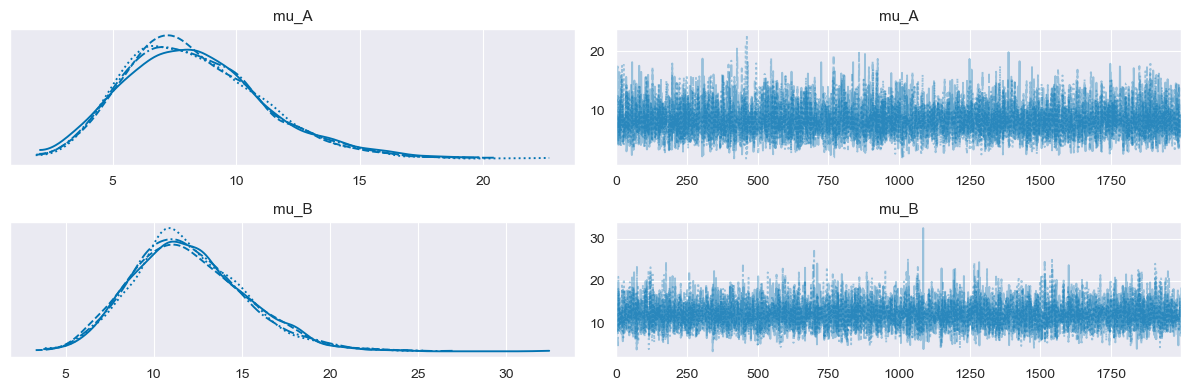

In [17]:
with model3:
    az.plot_trace(idata3)
plt.tight_layout()

Estraiamo le distribuzioni a priori dei due parametri da `idata3`.

In [13]:
mu_A = idata3.posterior['mu_A']
mu_B = idata3.posterior['mu_B']
mu_B.mean(), mu_A.mean()

(<xarray.DataArray 'mu_B' ()>
 array(11.81553763),
 <xarray.DataArray 'mu_A' ()>
 array(8.17939801))

Rappresentiamo graficamente le due distribuzioni a posteriori.

<Axes: title={'center': 'mu_B'}>

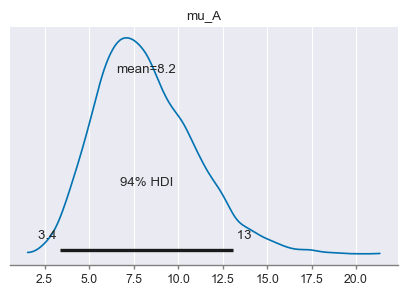

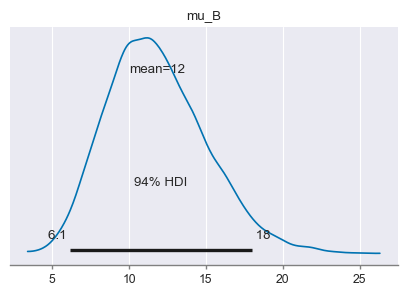

In [14]:
az.plot_posterior(mu_A)
az.plot_posterior(mu_B)

Eseguiamo un test di ipotesi bayesiano, ovvero ci chiediamo quale sia la probabilità che la media del numero di episodi di violenza di Mario sia maggiore di quello di Paolo. Per rispondere a questa domanda calcoliamo il numero di volte in cui `mu_B` è maggiore di `mu_A` nelle due distribuzioni a posteriori.

In [15]:
(mu_B > mu_A).mean()

<xarray.DataArray ()>
array(0.807)

Possiamo dunque dire che, nell'81% di casi, risulta che Paolo è più violento di Mario, se confrontiamo i valori dei parametri delle due distribuzioni a posteriori.

Il grafico seguente mostra le stime degli intervalli di credibilità del 94% per ciascuna delle 4 catene, pe i due parametri.

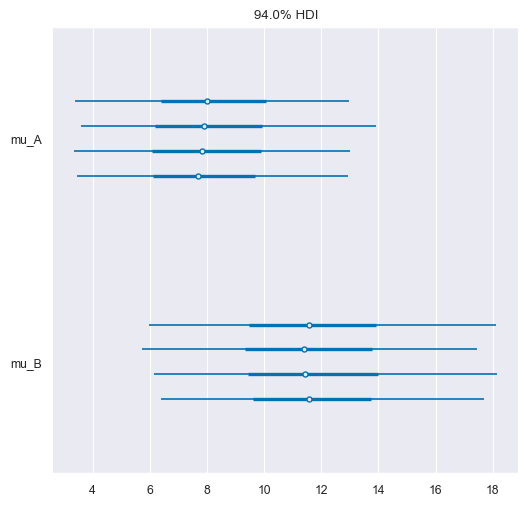

In [16]:
_ = az.plot_forest(idata3, var_names=["mu_A", "mu_B"])

Dato che gli intervalli di credibilità sono sovrapposti, si conclude dicendo che non ci sono evidenze credibili di una differenza. Ovvero, sulla base delle nostre credenze a priori e dei dati osservati, non possiamo concludere, ad un livello di certezza soggettiva del 94%, che Paolo sia più violento di Mario.

## Gli episodi di violenza futuri

Consideriamo ora il problema della predizione di dati futuri. Utilizziamo nuovamente il modello che abbiamo già usato in precedenza, ovvero `model3`.

Creiamo la distribuzione predittiva a posteriori per il parametro `mu_A`, ovvero la media del numero di eventi di violenza attesi in futuro per Mario.

In [22]:
with model3:
    post_pred = pm.sample_posterior_predictive(idata3)

In [23]:
post_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

Rappresentiamo la distribuzione predittiva a posteriori di `mu_A` con un istogramma.

<Axes: title={'center': 'episodes_A\n0'}>

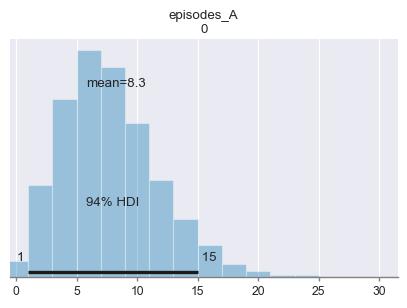

In [27]:
az.plot_posterior(post_pred.posterior_predictive.episodes_A, hdi_prob=0.94)

Facciamo la stessa cosa per Paolo.

<Axes: title={'center': 'episodes_B\n0'}>

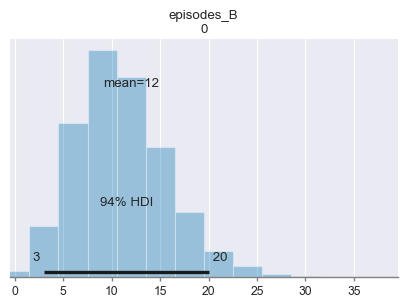

In [28]:
az.plot_posterior(post_pred.posterior_predictive.episodes_B, hdi_prob=0.94)


Sulla base delle nostre credenze precedenti e usando i dati che abbiamo osservato negli ultimi 6 mesi ci possiamo aspettare nei prossimi 6 mesi, con un grado di certezza soggettiva del 94%, che Mario produca un numero minimo di episodi di violenza pari a 1 e un numero massimo di episodi di violenza pari a 15; per Paolo ci possiamo aspettare un minimo di 3 episodi di violenza e un massimo di 20.


## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w